In [242]:
import os
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [243]:
root_path = '.\\dumpsite_data\\VOC2012'
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")
file_Annotations = os.path.join(train_path, "Annotations")

In [244]:
object_class = []
for each_xml in os.listdir(file_Annotations):
    pic_xml = os.path.join(file_Annotations, each_xml)
    tree = ET.parse(pic_xml)
    root = tree.getroot()
    for object_elem in root.findall('object'):
        name_elem_value = object_elem.find('name').text
        object_class.append(name_elem_value)
classes = set(object_class)
print(classes)


{'industry waste', 'construction waste', 'mining waste', 'agriculture forestry', 'domestic garbage', 'disposed garbage'}


In [245]:
label_maps = {}
for index, class_name in enumerate(classes):
    label_maps[class_name] = index
print(label_maps)

{'industry waste': 0, 'construction waste': 1, 'mining waste': 2, 'agriculture forestry': 3, 'domestic garbage': 4, 'disposed garbage': 5}


In [246]:
def label_name(label_num):
    class_name = {k for k, v in label_maps.items() if v == label_num}
    return list(class_name)[0]

##### Due to the problem of severe sample imbalance in the dumpsite dataset (Fig. 1a), we propose two training strategies, data augmentation (vertical flipping, horizontal
##### flipping, forward 90° rotation and reverse 90° rotation) and category balancing, to ensure the model’sefficiency during the training process

In [247]:
class  VOCDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        txt_file = os.path.join(root, "train.txt")
        with open(txt_file, 'r') as f:
            self.image_ids = f.read().strip().split()
        self.image_folder = os.path.join(root, "JPEGImages")
        self.ann_folder = os.path.join(root, "Annotations")

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_folder, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_folder, f"{img_id}.xml")

        img = np.array(Image.open(img_path).convert("RGB"))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            # print("label是:", label)
            labels.append(label_maps[label])
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            # if self.transforms:
            #     transform = self.transforms.normalize.transforms[0]
            #     if isinstance(transform, T.Resize):
            #         print("等比例缩放")
            #         scale_factor = transform.size[0] / img.width
            #         print(scale_factor)
            #         xmin = int(xmin * scale_factor)
            #         ymin = int(ymin * scale_factor)
            #         xmax = int(xmax * scale_factor)
            #         ymax = int(ymax * scale_factor)
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes":boxes, "labels":labels}
        print("转换前：", target['boxes'], target['labels'])
        if self.transforms:
            while True:
                img_np = np.array(img)
                img_aug, target_aug = self.transforms(img_np, target.copy())
                if torch.numel(target_aug['boxes']) > 0:
                    print("成功")
                    target_aug["boxes"] = self._clip_boxes(target_aug["boxes"], img_shape=img_aug.shape[1:])
                    print(self._check_bounding_box(target_aug["boxes"]))
                    print(target_aug["boxes"])
                    if self._check_bounding_box(target_aug["boxes"]):
                        img = img_aug
                        target = target_aug
                        break
                else:
                    print("失败的是:", idx)
        return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}

    def _unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        mean = torch.tensor(mean)[:, None, None]
        std = torch.tensor(std)[:, None, None]
        return image * std + mean

    # judge if the bounding box is in the image
    def _clip_boxes(self, boxes, img_shape):
        boxes[:, 0].clamp_(min=0, max=img_shape[0])
        boxes[:, 1].clamp_(min=0, max=img_shape[1])
        boxes[:, 2].clamp_(min=0, max=img_shape[0])
        boxes[:, 3].clamp_(min=0, max=img_shape[1])
        return boxes
    
    def _check_bounding_box(self, boxes):
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        condition_x = boxes[:, 0] < boxes[:, 2]
        condition_y = boxes[:, 1] < boxes[:, 3]
        condition = condition_x & condition_y
        return torch.all(condition).item()

    def compare_pic(self, idx=None):
        if idx == None:
            random_idx = random.randint(0, len(self.image_ids) - 1)
        else:
            random_idx = idx
        ori_pic = os.path.join("./dumpsite_data/VOC2012/train/JPEGImages", f'{self.image_ids[random_idx]}.jpg')
        ori_pic_ann = os.path.join("./dumpsite_data/VOC2012/train/Annotations", f"{self.image_ids[random_idx]}.xml")
        ori_pic = Image.open(ori_pic).convert("RGB")
        tree = ET.parse(ori_pic_ann)
        root = tree.getroot()
        ori_boxes = []
        ori_labels = []
        for bounding_box in root.findall('object'):
            label = bounding_box.find("name").text
            ori_labels.append(label)
            bbox = bounding_box.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            box = [xmin, ymin, xmax, ymax]
            ori_boxes.append(box)
        ori_draw = ImageDraw.Draw(ori_pic)
        for box, label in zip(ori_boxes, ori_labels):
            xmin, ymin, xmax, ymax = box
            ori_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
            ori_draw.text((xmin - 10, ymin - 10), label, fill="red")
            
        sample = self[random_idx]
        image, boxes, labels = sample['image'], sample['boxes'], sample['labels']
        image = self._unnormalize(image).permute(1, 2, 0).numpy()
        image = (image * 255).astype(np.uint8)
        image = F.to_pil_image(image)
        draw = ImageDraw.Draw(image)
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            draw.rectangle([xmin, ymin, xmax, ymax], outline="black", width=10)
            draw.text((xmin - 10, ymin - 10), label_name(label), fill="black")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(ori_pic)
        ax1.set_title('ori_pic')
        ax2.imshow(image)
        ax2.set_title('after_pic')
        plt.show()


In [248]:
class DetectionTransforms:
    def __init__(self, seed=42):
        self.augment = A.Compose([
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5), 
            A.Rotate(limit=90, p=0.5),
            A.Rotate(limit=-90, p=0.5), 
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        self.normalize = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    
    def __call__(self, image, targets):
        # albumentations  request the type of image is numpy not PIL
        transformed = self.augment(image=image, bboxes=targets['boxes'], labels=targets['labels'])
        image = transformed['image']
        targets['boxes'] = transformed['bboxes']
        targets['boxes'] = torch.tensor(targets["boxes"], dtype=torch.float32)
        targets['labels'] = transformed['labels']
        targets['labels'] = torch.tensor(targets["labels"], dtype=torch.int64)
        image = self.normalize(image=image)['image']
        print("转换后：", targets['boxes'], targets['labels'])
        return image, targets

In [249]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]



def collate_fn(batch):
    images = []
    targets = []
    for obj in batch:
        images.append(obj['image'])
        targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
    images = torch.stack(images, dim=0)
    return images, targets


transforms = DetectionTransforms()
dataset = VOCDataset(root='./dumpsite_data/VOC2012/train', transforms=transforms)
dataloader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn)

转换前： tensor([[ 119.,  954.,  181., 1022.]]) tensor([4])
转换后： tensor([[749.7064,   0.0000, 822.5429,  19.3691]]) tensor([4])
成功
True
tensor([[749.7064,   0.0000, 822.5429,  19.3691]])


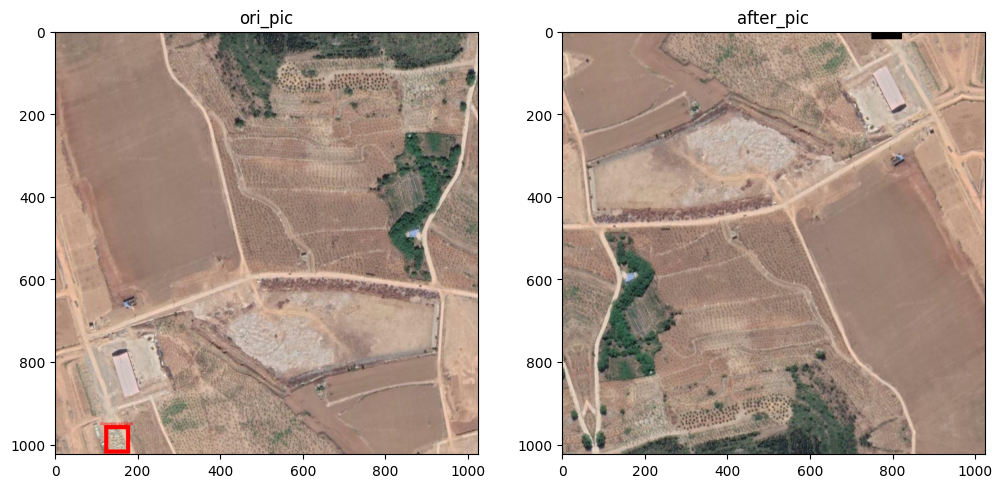

In [250]:
dataset.compare_pic(32)

#### 原图与处理后的图片对比（含有边框）

In [251]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision

In [252]:
num_classes = 6
model = fasterrcnn_resnet50_fpn(pretrained=True)
input_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes=num_classes)

c:\Users\learn\.conda\envs\pytorch_comp9444\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\learn\.conda\envs\pytorch_comp9444\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [253]:
model, model.roi_heads

(FasterRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       Resize(min_size=(800,), max_size=1333, mode='bilinear')
   )
   (backbone): BackboneWithFPN(
     (body): IntermediateLayerGetter(
       (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (bn1): FrozenBatchNorm2d(64, eps=0.0)
       (relu): ReLU(inplace=True)
       (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (layer1): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): FrozenBatchNorm2d(64, eps=0.0)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): FrozenBatchNorm2d(64, eps=0.0)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn3): FrozenBatchNorm2d(256, eps=0.0)
    

In [254]:
for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params, lr=0.0025, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

In [255]:
epochs = 24
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
for epoch in range(epochs):
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{box : label.to(device) for box, label in obj.items()} for obj in targets]
        loss = model(images, targets)
        losses = sum(loss for loss in loss.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    lr_scheduler.step()



转换前： tensor([[714., 278., 783., 394.]]) tensor([3])
转换后： tensor([[745.0407, 426.6406, 867.5133, 562.1861]]) tensor([3])
成功
True
tensor([[745.0407, 426.6406, 867.5133, 562.1861]])
转换前： tensor([[350., 636., 421., 704.]]) tensor([1])
转换后： tensor([[665.3117, 439.2223, 760.4618, 535.3506]]) tensor([1])
成功
True
tensor([[665.3117, 439.2223, 760.4618, 535.3506]])
转换前： tensor([[854., 841., 888., 878.]]) tensor([4])
转换后： tensor([[136., 841., 170., 878.]]) tensor([4])
成功
True
tensor([[136., 841., 170., 878.]])
转换前： tensor([[731., 880., 778., 925.],
        [467., 812., 618., 900.]]) tensor([4, 1])
转换后： tensor([[862.3984, 224.7563, 923.6962, 285.0474],
        [593.6851, 139.5514, 767.4728, 281.6306]]) tensor([4, 1])
成功
True
tensor([[862.3984, 224.7563, 923.6962, 285.0474],
        [593.6851, 139.5514, 767.4728, 281.6306]])
转换前： tensor([[636., 884., 739., 971.]]) tensor([4])
转换后： tensor([[631.3909,  33.8750, 765.1812, 168.5703]]) tensor([4])
成功
True
tensor([[631.3909,  33.8750, 765.1812, 168.5703]

ValueError: x_max is less than or equal to x_min for bbox (tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(4)).

转换前： tensor([[ 897.,  958.,  950., 1022.]]) tensor([4])
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([]) tensor([], dtype=torch.int64)
失败的是: 77
转换后： tensor([[6.4285e-40, 6.8733e-40, 6.8159e-40, 7.3325e-40]]) tensor([4])
成功
True
tensor([[6.4285e-40, 6.8733e-40, 6.8159e-40, 7.3325e-40]])


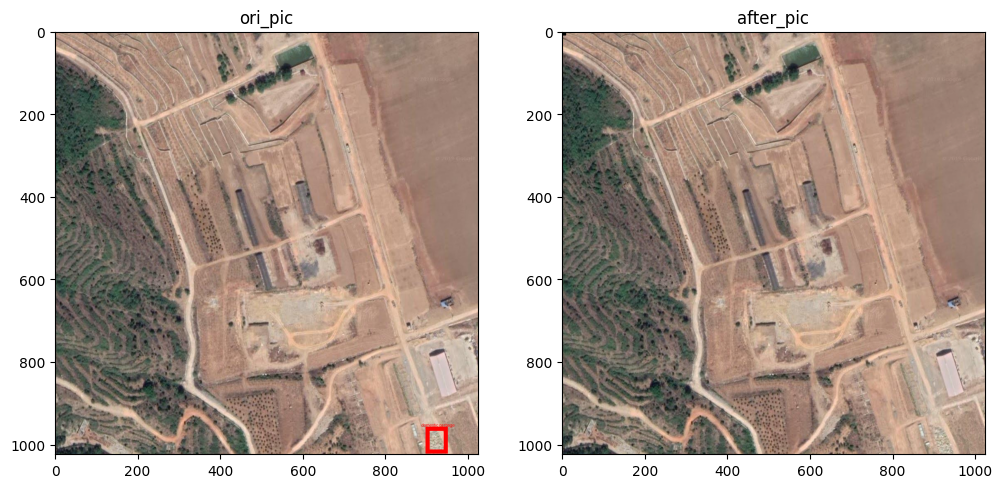

In [264]:
dataset.compare_pic(77)